In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# データの準備

 - [Binance Data - BTC/USD\[Minute\]](https://www.cryptodatadownload.com/cdd/Binance_BTCUSDT_minute.csv)

In [45]:
dataset = pd.read_csv('data/Binance_BTCUSDT_minute.csv', skiprows=1, index_col=1, parse_dates=True).sort_index()

feature_df = pd.DataFrame({
    '収益率': dataset['close'].pct_change(),
    'BTCの取引量': dataset['Volume BTC'],
    'USDTの取引量': dataset['Volume USDT'],
    '取引回数': dataset['tradecount'],
    '差分': dataset['open'] - dataset['close']
})

teacher_ser = dataset['close'].pct_change().shift(-1)
teacher_ser = teacher_ser.rename('teacher')

In [46]:
merged = pd.merge(teacher_ser, feature_df, left_index=True, right_index=True, how='inner').dropna()
teacher_ser = merged.pop('teacher')
feature_df = merged

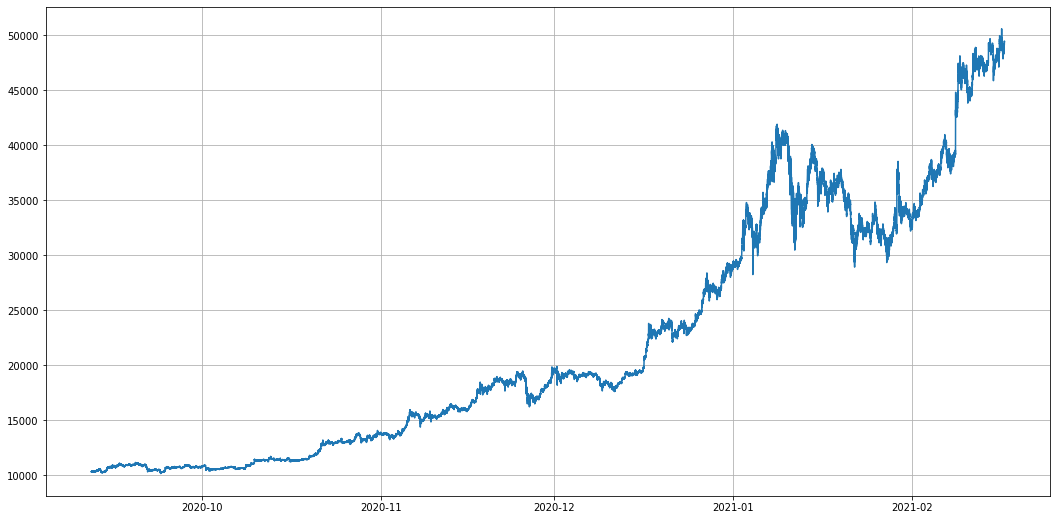

In [47]:
plt.figure(figsize=(18, 9))
plt.plot(dataset['close'])
plt.grid(True)
plt.show()

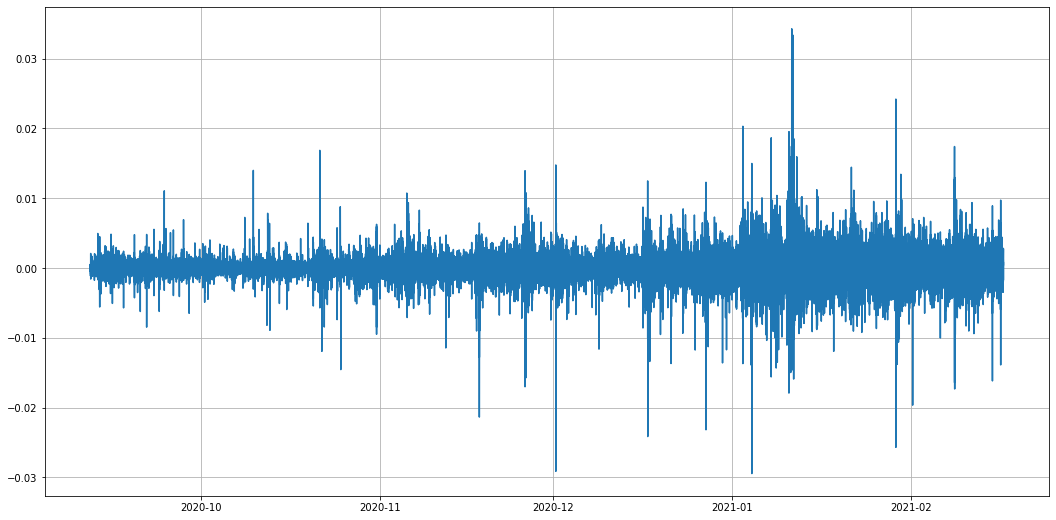

In [48]:
plt.figure(figsize=(18, 9))
plt.plot(teacher_ser)
plt.grid(True)
plt.show()

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_df, teacher_ser, test_size=0.3, shuffle=False)

In [50]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# モデルの構築

 - [Recurrentレイヤー#SimpleRNN - Keras Documentation](https://keras.io/ja/layers/recurrent/#simplernn)
 - [活性化関数 - Keras Documentation](https://keras.io/ja/activations/)
 - [レイヤーの重み初期化 - Keras Documentation](https://keras.io/ja/initializers/)

In [69]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense


特徴量の数 = X_train.shape[1]

# About LSTM
系列長の長さ = 60
出力の次元数 = 5

LSTM = Sequential([
    InputLayer(batch_input_shape=(None, 系列長の長さ, 特徴量の数), name='input_layer'),
    LSTM(units=出力の次元数, activation='linear', recurrent_activation='sigmoid', use_bias=False, name='internal_layer'),
    Dense(1, activation="linear", name="output_layer")
], name='LSTM')

In [70]:
LSTM.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
internal_layer (LSTM)        (None, 5)                 200       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 6         
Total params: 206
Trainable params: 206
Non-trainable params: 0
_________________________________________________________________


# 学習プロセスの設定

 - [最適化 - Keras Documentation](https://keras.io/ja/optimizers/)
 - [損失関数 - Keras Documentation](https://keras.io/ja/losses/)
 - [評価関数 - Keras Documentation](https://keras.io/ja/metrics/)

In [71]:
最適化アルゴリズム = 'adam'
損失関数 = 'mse'
評価関数_list  = ['mse']

LSTM.compile(
    optimizer=最適化アルゴリズム,
    loss=損失関数,
    metrics=評価関数_list
)

# 学習

In [72]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


バッチサイズ = 1000
エポック数 = 5000
# コールバックs = []
コールバックs = [EarlyStopping(monitor='val_loss', patience=10)]  # 最低10エポックはパラメーターを更新する

generator = TimeseriesGenerator(X_train, y_train, length=系列長の長さ, batch_size=バッチサイズ)
X, y = generator[0]

history = LSTM.fit(
    X, y, 
    validation_split=0.3,
    batch_size=バッチサイズ,
    epochs=エポック数,
    callbacks=コールバックs
)

Epoch 1/5000
1/1 [==============================] - 1s 820ms/step - loss: 4.1702e-04 - mse: 4.1702e-04 - val_loss: 3.5666e-04 - val_mse: 3.5666e-04
Epoch 2/5000
1/1 [==============================] - 0s 113ms/step - loss: 3.3588e-04 - mse: 3.3588e-04 - val_loss: 2.8218e-04 - val_mse: 2.8218e-04
Epoch 3/5000
1/1 [==============================] - 0s 143ms/step - loss: 2.6392e-04 - mse: 2.6392e-04 - val_loss: 2.1706e-04 - val_mse: 2.1706e-04
Epoch 4/5000
1/1 [==============================] - 0s 105ms/step - loss: 2.0123e-04 - mse: 2.0123e-04 - val_loss: 1.6129e-04 - val_mse: 1.6129e-04
Epoch 5/5000
1/1 [==============================] - 1s 909ms/step - loss: 1.4779e-04 - mse: 1.4779e-04 - val_loss: 1.1471e-04 - val_mse: 1.1471e-04
Epoch 6/5000
1/1 [==============================] - 0s 79ms/step - loss: 1.0343e-04 - mse: 1.0343e-04 - val_loss: 7.7054e-05 - val_mse: 7.7054e-05
Epoch 7/5000
1/1 [==============================] - 0s 84ms/step - loss: 6.7876e-05 - mse: 6.7876e-05 - val_loss:

In [73]:
学習推移_df = pd.DataFrame(history.history, index=history.epoch)
学習推移_df.head()

,loss,mse,val_loss,val_mse
0,0.000417,0.000417,0.000357,0.000357
1,0.000336,0.000336,0.000282,0.000282
2,0.000264,0.000264,0.000217,0.000217
3,0.000201,0.000201,0.000161,0.000161
4,0.000148,0.000148,0.000115,0.000115


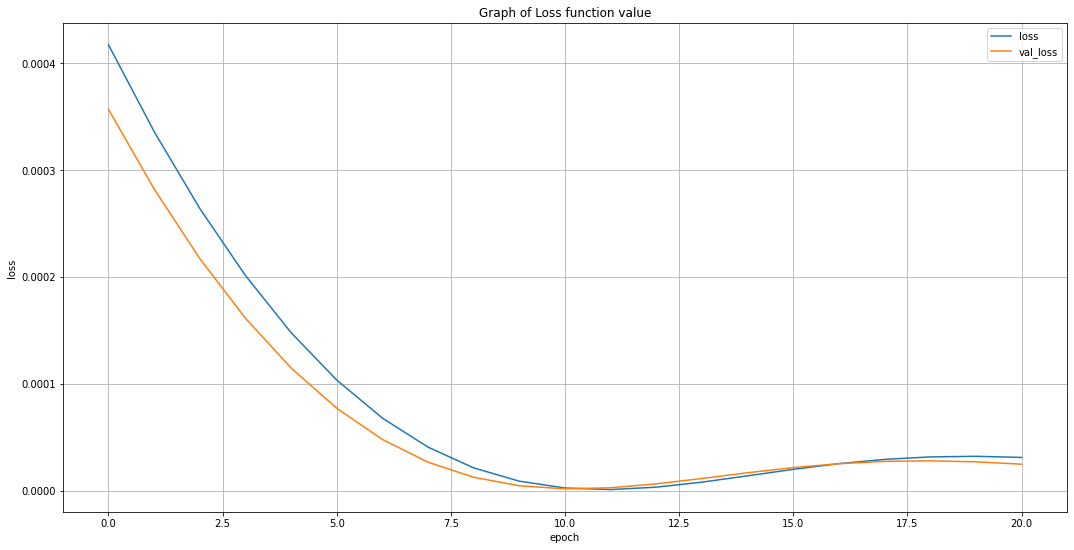

In [74]:
import matplotlib.pyplot as plt


plt.figure(figsize=(18, 9))
plt.title("Graph of Loss function value")
plt.plot(学習推移_df['loss'], label='loss')
plt.plot(学習推移_df['val_loss'], label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 評価

In [75]:
X, y = TimeseriesGenerator(X_test, y_test.values, length=系列長の長さ, batch_size=10000)[0]

In [76]:
pd.Series(
    LSTM.evaluate(X, y),
    index=LSTM.metrics_names,
    name='評価指標'
)

313/313 [==============================] - 3s 9ms/step - loss: 2.8879e-05 - mse: 2.8879e-05


loss    0.000029
mse     0.000029
Name: 評価指標, dtype: float64

# 予測

In [77]:
y_pred = LSTM.predict(X.reshape(-1, 系列長の長さ, 特徴量の数))

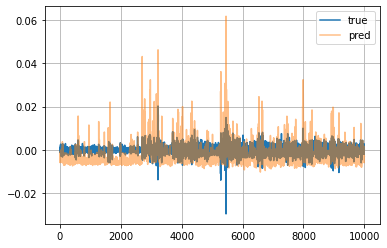

In [81]:
plt.plot(y, label='true')
plt.plot(y_pred, label='pred', alpha=0.5)
plt.grid()
plt.legend()
plt.show()

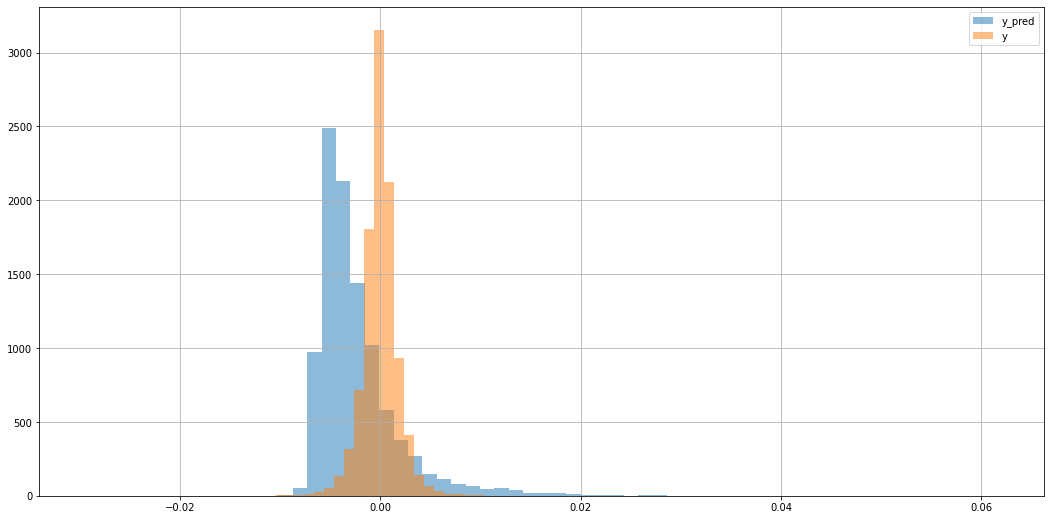

In [79]:
plt.figure(figsize=(18, 9))
plt.hist(y_pred, bins=50, label='y_pred', alpha=0.5)
plt.hist(y, bins=50, label='y', alpha=0.5)
plt.grid()
plt.legend()
plt.show()